Multi-Layer perceptron for parabolic dynamics prediction
---------------

This notebook loads the data generated from the pre-processing notebook and uses them to train and test a multi-layer perceptron for predicting the three parabolic coefficients that approximate the dynamics of the datasets melodic motifs.

This model and the results obtained are reported in:

    Ortega, F.J.M., Perez, A., Ramirez, R. Predicting dynamics in violin pieces with features from melodic motifs. In: Proceedings of the 12th International Workshop on Machine Learning and Music (MML2019). Würzburg, Germany. 2019.

#### Load and preprocess training data

In [71]:
import numpy as np
import pandas as pd

np.random.seed(1728)

def filter_outliers(df, cols=None, outlier_factor=5.):
    if cols is None:
        cols = (df.dtypes == 'float64') | (df.dtypes == 'int64')
    numdf = df.loc[:, cols]
    thold = outlier_factor * (numdf.quantile(0.75) - numdf.quantile(0.25))
    return df[((numdf - thold) < 0).all(axis=1)]


#  read csv
fhandle = open('data/newviolin.csv', 'r')
df = pd.read_csv(fhandle)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print('initial size: ' + str(len(df)))

# eliminate missing values, insufficient dynamics data (dynamicsX0 = -inf)
df.dropna()
df = df.loc[df.dynamicsX0 != -np.inf,:]

#  filter by motif size
df = df[df.numberOfNotes > 3]
df = df[df.numberOfNotes < 20]

print('size after N/A and small motif crop: ' + str(len(df)))

#  one-hot encode nominal values
for attrib in ['metricStrength', 'pieceMode', 'initialChord', 'finalChord']:
    df = pd.concat([df, pd.get_dummies(df[attrib], prefix=attrib)], axis=1)
    df.drop([attrib], axis=1, inplace=True)

#  shuffle rows
intact = df
df = df.sample(frac=1)
    
#  remove unused attributes
df = df.drop(['pieceId', 'motifId', 'pieceDynMean', 'pieceDynStd', 'startTime', 'durationSecs'], axis=1)

#  filter outliers/extreme values
df = filter_outliers(df, outlier_factor=10)
print('size w/o outliers: ' + str(len(df)))

#  standardize features
moments = np.zeros((3,2)) # output mean and std for reverting predictions
outs = df.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']]
moments[:,0] = outs.mean().to_numpy()
moments[:,1] = outs.std().to_numpy()
nums = df.loc[:,(df.dtypes == 'float64') | (df.dtypes == 'int64')]
df.loc[:, (df.dtypes == 'float64') | (df.dtypes == 'int64')] = (nums - nums.mean()) / nums.std()
        
        
#  split train/test
train = df.iloc[0:(len(df)*9)//10,:]
test = df.iloc[(len(df)*9)//10:,:]
print('lengths: {tr}, {t}'.format(tr=len(train), t=len(test)))


initial size: 27184
size after N/A and small motif crop: 16404
size w/o outliers: 15640
lengths: 14076, 1564


#### Define the neural network

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1728)
_, attrs = train.shape
attrs = attrs - 3 # 3 outputs
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc05 = nn.Linear(attrs, attrs)
        self.fc1 = nn.Linear(attrs, attrs//2 + 1)
        self.fc2 = nn.Linear(attrs//2 + 1, attrs//2 + 1)
        self.fc3 = nn.Linear(attrs//2 + 1, 3)

    def forward(self, x):
        x = F.relu(self.fc05(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(net.parameters()) #optim.SGD(net.parameters(), lr=0.2, momentum=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1700, gamma=0.1)

#### Train the model

In [73]:
epochs = 2500
batch_size = 100
train_out = train.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']].to_numpy().astype('float64')
train_in = train.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1).to_numpy().astype('float64')
train_np = np.concatenate((train_in, train_out), axis=1)
for t in range(epochs):
    np.random.shuffle(train_np)
    input_dt = torch.Tensor(train_np[:,:-3])
    truth = torch.Tensor(train_np[:,-3:])
    i = 0
    accloss = []
    accR = []
    while i < len(input_dt):
        if (i + batch_size < len(input_dt)):
            x = input_dt[i:i + batch_size,:]
            y = truth[i:i + batch_size,:]
        else:
            x = input_dt[i:,:]
            y = truth[i:,:]
        i = i + batch_size
        out = net(x)
        loss = loss_fn(out, y)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        pred = out.detach().numpy()
        accloss.append(loss.item())
        accR.append(np.corrcoef(pred[:,0], y[:,0])[0,1])
    print('epoch: ' + str(t) + ' loss: ' + str(np.mean(accloss)) + '\tlr: ' + str(optimizer.param_groups[0]['lr']) + '\tr: {pr}'.format(pr=np.mean(accR)))
    scheduler.step()

epoch: 0 loss: 0.9953936537106832	lr: 0.001	r: 0.035673650219219484
epoch: 1 loss: 0.9758126883642048	lr: 0.001	r: 0.13401064520505046
epoch: 2 loss: 0.9655465077846608	lr: 0.001	r: 0.15646987186085712
epoch: 3 loss: 0.9580395247073884	lr: 0.001	r: 0.17148433448685022
epoch: 4 loss: 0.9501960260648254	lr: 0.001	r: 0.19081548552767502
epoch: 5 loss: 0.9428277861141989	lr: 0.001	r: 0.20518336053321318
epoch: 6 loss: 0.9351521098444647	lr: 0.001	r: 0.22250266289779702
epoch: 7 loss: 0.9287079779814321	lr: 0.001	r: 0.2337765467603802
epoch: 8 loss: 0.9217729251435463	lr: 0.001	r: 0.24755403794938602
epoch: 9 loss: 0.9101615949725428	lr: 0.001	r: 0.2673887904260603
epoch: 10 loss: 0.9044979884692118	lr: 0.001	r: 0.27932034904732844
epoch: 11 loss: 0.8935519247613055	lr: 0.001	r: 0.29570428552699135
epoch: 12 loss: 0.8845339007411442	lr: 0.001	r: 0.30606141751092797
epoch: 13 loss: 0.8789679742028528	lr: 0.001	r: 0.3142806841790563
epoch: 14 loss: 0.8683159528894627	lr: 0.001	r: 0.3293172413

epoch: 122 loss: 0.6052079441699576	lr: 0.001	r: 0.623603240158385
epoch: 123 loss: 0.6021623309199692	lr: 0.001	r: 0.6262387119485368
epoch: 124 loss: 0.5999042309345083	lr: 0.001	r: 0.6273975710181383
epoch: 125 loss: 0.6048204476106251	lr: 0.001	r: 0.6258243497943378
epoch: 126 loss: 0.6012250563354357	lr: 0.001	r: 0.6241152460018969
epoch: 127 loss: 0.6013528643347693	lr: 0.001	r: 0.6289426534334068
epoch: 128 loss: 0.6004259129788013	lr: 0.001	r: 0.6320680870418129
epoch: 129 loss: 0.5982911079487903	lr: 0.001	r: 0.6337020597097955
epoch: 130 loss: 0.5978515399685989	lr: 0.001	r: 0.633494847178762
epoch: 131 loss: 0.6004084845383962	lr: 0.001	r: 0.6270128901966212
epoch: 132 loss: 0.5970991611057985	lr: 0.001	r: 0.6267446403237262
epoch: 133 loss: 0.5972330940107927	lr: 0.001	r: 0.6340836449202737
epoch: 134 loss: 0.5978810702655333	lr: 0.001	r: 0.633135825414849
epoch: 135 loss: 0.5954952778968405	lr: 0.001	r: 0.6367336789217295
epoch: 136 loss: 0.5948497399370721	lr: 0.001	r: 0.

epoch: 243 loss: 0.5544672200443052	lr: 0.001	r: 0.6754956782186485
epoch: 244 loss: 0.5543297300947473	lr: 0.001	r: 0.6764760338937092
epoch: 245 loss: 0.5519737668916689	lr: 0.001	r: 0.6750654619485866
epoch: 246 loss: 0.5506659372055784	lr: 0.001	r: 0.6814924461178197
epoch: 247 loss: 0.5536442145388177	lr: 0.001	r: 0.6735409343536649
epoch: 248 loss: 0.5505760394512339	lr: 0.001	r: 0.6722959233900341
epoch: 249 loss: 0.5530025715946306	lr: 0.001	r: 0.6774772386262903
epoch: 250 loss: 0.5534093259496892	lr: 0.001	r: 0.6723011048055767
epoch: 251 loss: 0.5486485539598668	lr: 0.001	r: 0.6748258195103057
epoch: 252 loss: 0.5496486919991513	lr: 0.001	r: 0.6811837256011277
epoch: 253 loss: 0.5563357425919662	lr: 0.001	r: 0.6735000361106571
epoch: 254 loss: 0.5522692311317363	lr: 0.001	r: 0.6725479809214687
epoch: 255 loss: 0.5491810749608574	lr: 0.001	r: 0.6789360585866545
epoch: 256 loss: 0.5511715498799128	lr: 0.001	r: 0.6812185996933043
epoch: 257 loss: 0.551694855199638	lr: 0.001	r: 

epoch: 364 loss: 0.5317985538049792	lr: 0.001	r: 0.6932779763409294
epoch: 365 loss: 0.5306810180768899	lr: 0.001	r: 0.6936065757063009
epoch: 366 loss: 0.5328382959602572	lr: 0.001	r: 0.6918592713771029
epoch: 367 loss: 0.5320487692423747	lr: 0.001	r: 0.6923295801971389
epoch: 368 loss: 0.5323962144395138	lr: 0.001	r: 0.6953523396637051
epoch: 369 loss: 0.5328350060797752	lr: 0.001	r: 0.6936029323309939
epoch: 370 loss: 0.5308652735771017	lr: 0.001	r: 0.6931398411708367
epoch: 371 loss: 0.5301472493942748	lr: 0.001	r: 0.6946825586143498
epoch: 372 loss: 0.528915117184321	lr: 0.001	r: 0.6988054899844324
epoch: 373 loss: 0.5320104155557376	lr: 0.001	r: 0.694161067889227
epoch: 374 loss: 0.531255951798554	lr: 0.001	r: 0.6961535264893529
epoch: 375 loss: 0.5314696845433391	lr: 0.001	r: 0.691206951887155
epoch: 376 loss: 0.5308068559524861	lr: 0.001	r: 0.6921559672986669
epoch: 377 loss: 0.5318261617464377	lr: 0.001	r: 0.6940082227325508
epoch: 378 loss: 0.5280884011840143	lr: 0.001	r: 0.6

epoch: 486 loss: 0.51850525981991	lr: 0.001	r: 0.709159798788421
epoch: 487 loss: 0.5202071901331556	lr: 0.001	r: 0.7045747073468884
epoch: 488 loss: 0.5212011574007941	lr: 0.001	r: 0.7025347099271113
epoch: 489 loss: 0.5162459778870251	lr: 0.001	r: 0.7037856997555574
epoch: 490 loss: 0.5193376422773862	lr: 0.001	r: 0.707820344091328
epoch: 491 loss: 0.5197577742820091	lr: 0.001	r: 0.7078087305706084
epoch: 492 loss: 0.5207117039261134	lr: 0.001	r: 0.7021725112199376
epoch: 493 loss: 0.5173228522564502	lr: 0.001	r: 0.7043041975952107
epoch: 494 loss: 0.5187803823897179	lr: 0.001	r: 0.7054574977732296
epoch: 495 loss: 0.5174633091223155	lr: 0.001	r: 0.7045900494996947
epoch: 496 loss: 0.5188590279707672	lr: 0.001	r: 0.7037297970993964
epoch: 497 loss: 0.5170603491735797	lr: 0.001	r: 0.7030971528461684
epoch: 498 loss: 0.5188671965548333	lr: 0.001	r: 0.7037705051830775
epoch: 499 loss: 0.5202948032541478	lr: 0.001	r: 0.703455218294302
epoch: 500 loss: 0.5194310814353591	lr: 0.001	r: 0.70

epoch: 608 loss: 0.5106174119398104	lr: 0.001	r: 0.7123681673993644
epoch: 609 loss: 0.5115337652940277	lr: 0.001	r: 0.7117785374081906
epoch: 610 loss: 0.5076445226973676	lr: 0.001	r: 0.714210456716818
epoch: 611 loss: 0.5113989252147945	lr: 0.001	r: 0.7118549676333393
epoch: 612 loss: 0.5105490185690265	lr: 0.001	r: 0.7128003543247982
epoch: 613 loss: 0.5080483073883868	lr: 0.001	r: 0.711046642238858
epoch: 614 loss: 0.5092238542881418	lr: 0.001	r: 0.7126921846078508
epoch: 615 loss: 0.509032741294685	lr: 0.001	r: 0.713286088555013
epoch: 616 loss: 0.509232740664313	lr: 0.001	r: 0.7158335725415093
epoch: 617 loss: 0.5116344333117735	lr: 0.001	r: 0.714096270421735
epoch: 618 loss: 0.507782685418501	lr: 0.001	r: 0.7135023967316401
epoch: 619 loss: 0.5103592506959929	lr: 0.001	r: 0.7095845863850702
epoch: 620 loss: 0.511211429716002	lr: 0.001	r: 0.7098297848620556
epoch: 621 loss: 0.5100000838861398	lr: 0.001	r: 0.7118256067682779
epoch: 622 loss: 0.5089030401081058	lr: 0.001	r: 0.71686

epoch: 729 loss: 0.5024303223224397	lr: 0.001	r: 0.7218428721527863
epoch: 730 loss: 0.5031166884070593	lr: 0.001	r: 0.7185152417958278
epoch: 731 loss: 0.5023038072366242	lr: 0.001	r: 0.7206507798104942
epoch: 732 loss: 0.5037907266870458	lr: 0.001	r: 0.7211444875616576
epoch: 733 loss: 0.5002272951264753	lr: 0.001	r: 0.7220807397668866
epoch: 734 loss: 0.5005607309070885	lr: 0.001	r: 0.7235007735149591
epoch: 735 loss: 0.5013286617208035	lr: 0.001	r: 0.7183554587902596
epoch: 736 loss: 0.5000250022462074	lr: 0.001	r: 0.7219827238003158
epoch: 737 loss: 0.5008613900512668	lr: 0.001	r: 0.7212792456778411
epoch: 738 loss: 0.5035230635751223	lr: 0.001	r: 0.7184237706943698
epoch: 739 loss: 0.5001913395756525	lr: 0.001	r: 0.7226423006974985
epoch: 740 loss: 0.499366764269822	lr: 0.001	r: 0.7211403286921171
epoch: 741 loss: 0.5007950376111565	lr: 0.001	r: 0.7188642018167407
epoch: 742 loss: 0.5010655858415238	lr: 0.001	r: 0.7211270257898436
epoch: 743 loss: 0.4993871048832616	lr: 0.001	r: 

epoch: 850 loss: 0.49562245100102525	lr: 0.001	r: 0.7265030811582618
epoch: 851 loss: 0.4971169212185745	lr: 0.001	r: 0.7236942074029183
epoch: 852 loss: 0.49436030404787534	lr: 0.001	r: 0.7235409576658466
epoch: 853 loss: 0.495437150728618	lr: 0.001	r: 0.7248674266815951
epoch: 854 loss: 0.4945537513452219	lr: 0.001	r: 0.7278576928357584
epoch: 855 loss: 0.4932131843363985	lr: 0.001	r: 0.7271811039055256
epoch: 856 loss: 0.4944739233940206	lr: 0.001	r: 0.7255379124764956
epoch: 857 loss: 0.4956513431900782	lr: 0.001	r: 0.7263527924745043
epoch: 858 loss: 0.49753356064465026	lr: 0.001	r: 0.7225553153948523
epoch: 859 loss: 0.49850221411556217	lr: 0.001	r: 0.7254308948698849
epoch: 860 loss: 0.4964982822854468	lr: 0.001	r: 0.7252667109495881
epoch: 861 loss: 0.49579951928016985	lr: 0.001	r: 0.7252028237176086
epoch: 862 loss: 0.4924681049289433	lr: 0.001	r: 0.7289116242298067
epoch: 863 loss: 0.4974118414077353	lr: 0.001	r: 0.7235963703751748
epoch: 864 loss: 0.4967400968497527	lr: 0.00

epoch: 971 loss: 0.4903806374005392	lr: 0.001	r: 0.7298361521181944
epoch: 972 loss: 0.490581510126168	lr: 0.001	r: 0.730862200207359
epoch: 973 loss: 0.4909115983239302	lr: 0.001	r: 0.7300386626869748
epoch: 974 loss: 0.48905954737189816	lr: 0.001	r: 0.7315255937686158
epoch: 975 loss: 0.4896060295984255	lr: 0.001	r: 0.7291884569935653
epoch: 976 loss: 0.4913985769376687	lr: 0.001	r: 0.7307632489518171
epoch: 977 loss: 0.4897411192985291	lr: 0.001	r: 0.7299802336664509
epoch: 978 loss: 0.48882747288291334	lr: 0.001	r: 0.7278942927917392
epoch: 979 loss: 0.48982795755913916	lr: 0.001	r: 0.7276977118632731
epoch: 980 loss: 0.48914513499178786	lr: 0.001	r: 0.7314813532072191
epoch: 981 loss: 0.4915182125483844	lr: 0.001	r: 0.7287701024438666
epoch: 982 loss: 0.4909734954225256	lr: 0.001	r: 0.7300484368932041
epoch: 983 loss: 0.49073252779372195	lr: 0.001	r: 0.7293899159864448
epoch: 984 loss: 0.490620067990418	lr: 0.001	r: 0.7276787383073896
epoch: 985 loss: 0.4889603673566318	lr: 0.001	

epoch: 1090 loss: 0.487873227249646	lr: 0.001	r: 0.7357939946103764
epoch: 1091 loss: 0.4884730273104729	lr: 0.001	r: 0.7301673704366388
epoch: 1092 loss: 0.48841182242894005	lr: 0.001	r: 0.7323746827570808
epoch: 1093 loss: 0.4877119778741336	lr: 0.001	r: 0.7336826586940988
epoch: 1094 loss: 0.48941563439707386	lr: 0.001	r: 0.7299611997677146
epoch: 1095 loss: 0.48804781770875266	lr: 0.001	r: 0.7322228638908467
epoch: 1096 loss: 0.4879032181087115	lr: 0.001	r: 0.7325213344451453
epoch: 1097 loss: 0.4868838330532642	lr: 0.001	r: 0.730944571318373
epoch: 1098 loss: 0.4876374800999959	lr: 0.001	r: 0.7339664119768394
epoch: 1099 loss: 0.4871466948208234	lr: 0.001	r: 0.7314118249812248
epoch: 1100 loss: 0.4856357530076453	lr: 0.001	r: 0.736646855499742
epoch: 1101 loss: 0.4851050042936988	lr: 0.001	r: 0.731618851896153
epoch: 1102 loss: 0.4890749401657294	lr: 0.001	r: 0.7318346333818135
epoch: 1103 loss: 0.4888495291378481	lr: 0.001	r: 0.7289219302700456
epoch: 1104 loss: 0.487728559379036

epoch: 1209 loss: 0.48247257065265736	lr: 0.001	r: 0.736579522089518
epoch: 1210 loss: 0.48506196466743523	lr: 0.001	r: 0.7378352604295197
epoch: 1211 loss: 0.4829699012404638	lr: 0.001	r: 0.7316925948740766
epoch: 1212 loss: 0.4815167890372851	lr: 0.001	r: 0.7363346666587056
epoch: 1213 loss: 0.4854615905606155	lr: 0.001	r: 0.7363247174227974
epoch: 1214 loss: 0.48359344254994224	lr: 0.001	r: 0.7361443718761781
epoch: 1215 loss: 0.48376782143369634	lr: 0.001	r: 0.7375318343724205
epoch: 1216 loss: 0.4845879843049016	lr: 0.001	r: 0.7322212213054049
epoch: 1217 loss: 0.4832946311497519	lr: 0.001	r: 0.734513271506486
epoch: 1218 loss: 0.48130161648100994	lr: 0.001	r: 0.736796083608643
epoch: 1219 loss: 0.4840287346366449	lr: 0.001	r: 0.7360838779154059
epoch: 1220 loss: 0.4825098747057272	lr: 0.001	r: 0.7363235059328133
epoch: 1221 loss: 0.48286577678741294	lr: 0.001	r: 0.7377901109292302
epoch: 1222 loss: 0.4848963899392608	lr: 0.001	r: 0.7324011255602394
epoch: 1223 loss: 0.48423535392

epoch: 1328 loss: 0.4820648708664779	lr: 0.001	r: 0.7378115441213862
epoch: 1329 loss: 0.4807007999707621	lr: 0.001	r: 0.7389034433876848
epoch: 1330 loss: 0.48135234764281737	lr: 0.001	r: 0.7421352491858111
epoch: 1331 loss: 0.48094309729041784	lr: 0.001	r: 0.7391895849012051
epoch: 1332 loss: 0.48170562289285324	lr: 0.001	r: 0.7415347035281286
epoch: 1333 loss: 0.4802157572397949	lr: 0.001	r: 0.7391901533238826
epoch: 1334 loss: 0.4812754656828887	lr: 0.001	r: 0.7382934110917233
epoch: 1335 loss: 0.48152686391316407	lr: 0.001	r: 0.7394926197925938
epoch: 1336 loss: 0.4820550800637996	lr: 0.001	r: 0.7384015894622218
epoch: 1337 loss: 0.4811688205029102	lr: 0.001	r: 0.7377954567364876
epoch: 1338 loss: 0.48142826536023026	lr: 0.001	r: 0.7415598346955157
epoch: 1339 loss: 0.4826497247455813	lr: 0.001	r: 0.7353012739169588
epoch: 1340 loss: 0.480133019440563	lr: 0.001	r: 0.738991883135039
epoch: 1341 loss: 0.47988625409755303	lr: 0.001	r: 0.7377595294646787
epoch: 1342 loss: 0.4811219006

epoch: 1447 loss: 0.47984660411557406	lr: 0.001	r: 0.740107049717512
epoch: 1448 loss: 0.478025144719063	lr: 0.001	r: 0.745741308911268
epoch: 1449 loss: 0.4798228793533136	lr: 0.001	r: 0.7398383280544566
epoch: 1450 loss: 0.4785154335042264	lr: 0.001	r: 0.7396920944294746
epoch: 1451 loss: 0.4807112935587024	lr: 0.001	r: 0.7425151690891968
epoch: 1452 loss: 0.4796028399298377	lr: 0.001	r: 0.7377683636128577
epoch: 1453 loss: 0.47833050924835474	lr: 0.001	r: 0.743804654286615
epoch: 1454 loss: 0.47852364119063034	lr: 0.001	r: 0.7431238681718809
epoch: 1455 loss: 0.4781314553098476	lr: 0.001	r: 0.7384900994790794
epoch: 1456 loss: 0.479959931990779	lr: 0.001	r: 0.7414240315790447
epoch: 1457 loss: 0.4808101971098717	lr: 0.001	r: 0.7379289460199996
epoch: 1458 loss: 0.48081436520772625	lr: 0.001	r: 0.7365649218277774
epoch: 1459 loss: 0.47883939912133183	lr: 0.001	r: 0.7395450801989841
epoch: 1460 loss: 0.47843344181987413	lr: 0.001	r: 0.7403484222800806
epoch: 1461 loss: 0.4793512072968

epoch: 1566 loss: 0.4798190285128059	lr: 0.001	r: 0.7435531746490646
epoch: 1567 loss: 0.47937785268675354	lr: 0.001	r: 0.7404486341554618
epoch: 1568 loss: 0.47582830097658413	lr: 0.001	r: 0.7419673478239102
epoch: 1569 loss: 0.47670952140862216	lr: 0.001	r: 0.7447536820007503
epoch: 1570 loss: 0.47617662248882	lr: 0.001	r: 0.743536926825428
epoch: 1571 loss: 0.4759995318050926	lr: 0.001	r: 0.7416572137167764
epoch: 1572 loss: 0.47683911289729125	lr: 0.001	r: 0.7390029117060316
epoch: 1573 loss: 0.47616186103922253	lr: 0.001	r: 0.7431937897057086
epoch: 1574 loss: 0.4766323357186419	lr: 0.001	r: 0.7436973796469868
epoch: 1575 loss: 0.47704073068097974	lr: 0.001	r: 0.7407230885704972
epoch: 1576 loss: 0.4756339139549445	lr: 0.001	r: 0.7427428577106011
epoch: 1577 loss: 0.47763663509213333	lr: 0.001	r: 0.7417189801455636
epoch: 1578 loss: 0.47662805855696927	lr: 0.001	r: 0.7451136602243076
epoch: 1579 loss: 0.47754792435794857	lr: 0.001	r: 0.74182049349216
epoch: 1580 loss: 0.4773505488

epoch: 1685 loss: 0.4747729648089578	lr: 0.001	r: 0.7440885221282894
epoch: 1686 loss: 0.4749761942430591	lr: 0.001	r: 0.7405580659946298
epoch: 1687 loss: 0.47676854776152483	lr: 0.001	r: 0.7406483600153686
epoch: 1688 loss: 0.4771150526002789	lr: 0.001	r: 0.7423158358594812
epoch: 1689 loss: 0.47633577175174197	lr: 0.001	r: 0.744239390860449
epoch: 1690 loss: 0.4759126159738987	lr: 0.001	r: 0.7430022303393935
epoch: 1691 loss: 0.47516159597018087	lr: 0.001	r: 0.7429061491003052
epoch: 1692 loss: 0.4747863473198938	lr: 0.001	r: 0.7443234485550585
epoch: 1693 loss: 0.4762022135950995	lr: 0.001	r: 0.7395600832268939
epoch: 1694 loss: 0.4761494212116755	lr: 0.001	r: 0.7422631226181137
epoch: 1695 loss: 0.4744271775509449	lr: 0.001	r: 0.74618396224187
epoch: 1696 loss: 0.4751154110364035	lr: 0.001	r: 0.7423746717237815
epoch: 1697 loss: 0.4760723048490835	lr: 0.001	r: 0.7449069316307249
epoch: 1698 loss: 0.4766630156243101	lr: 0.001	r: 0.7420136953552953
epoch: 1699 loss: 0.47558291626314

epoch: 1803 loss: 0.44694849933292846	lr: 0.0001	r: 0.7632948789281614
epoch: 1804 loss: 0.44679861880363303	lr: 0.0001	r: 0.7622584883288964
epoch: 1805 loss: 0.44652838106696485	lr: 0.0001	r: 0.7636626862692839
epoch: 1806 loss: 0.44722599763396786	lr: 0.0001	r: 0.7637254966810951
epoch: 1807 loss: 0.4468824599228852	lr: 0.0001	r: 0.7676216583820545
epoch: 1808 loss: 0.4466138017093036	lr: 0.0001	r: 0.763112576887409
epoch: 1809 loss: 0.44674094518025714	lr: 0.0001	r: 0.7641487576012393
epoch: 1810 loss: 0.44686539481717646	lr: 0.0001	r: 0.7652577348119396
epoch: 1811 loss: 0.44681044250515334	lr: 0.0001	r: 0.7624242644296483
epoch: 1812 loss: 0.44677675298765196	lr: 0.0001	r: 0.7647135621808969
epoch: 1813 loss: 0.44684272497258287	lr: 0.0001	r: 0.7660801021634345
epoch: 1814 loss: 0.44697818963240227	lr: 0.0001	r: 0.7629551183211858
epoch: 1815 loss: 0.4468978719508394	lr: 0.0001	r: 0.7646540693304085
epoch: 1816 loss: 0.44666122037468226	lr: 0.0001	r: 0.7674001169990116
epoch: 181

epoch: 1920 loss: 0.44624809487491635	lr: 0.0001	r: 0.7665626305085107
epoch: 1921 loss: 0.4461616818786513	lr: 0.0001	r: 0.7620044469697825
epoch: 1922 loss: 0.44623905060984564	lr: 0.0001	r: 0.7655579279338307
epoch: 1923 loss: 0.4461328845920292	lr: 0.0001	r: 0.7605947947112586
epoch: 1924 loss: 0.44621252612019263	lr: 0.0001	r: 0.7680304424166597
epoch: 1925 loss: 0.44618728165085436	lr: 0.0001	r: 0.7643569404964613
epoch: 1926 loss: 0.44605161260205806	lr: 0.0001	r: 0.7673438835954703
epoch: 1927 loss: 0.4459346649071849	lr: 0.0001	r: 0.7650013400323155
epoch: 1928 loss: 0.4462176362673442	lr: 0.0001	r: 0.7666315374364765
epoch: 1929 loss: 0.4460438384231946	lr: 0.0001	r: 0.7646293273310395
epoch: 1930 loss: 0.4465996944312508	lr: 0.0001	r: 0.7639514577307603
epoch: 1931 loss: 0.4461796793109136	lr: 0.0001	r: 0.766773354841776
epoch: 1932 loss: 0.4461704131136549	lr: 0.0001	r: 0.7632800527440758
epoch: 1933 loss: 0.4461395480531327	lr: 0.0001	r: 0.7655922245543104
epoch: 1934 loss

epoch: 2037 loss: 0.4458416180407747	lr: 0.0001	r: 0.7660853134263507
epoch: 2038 loss: 0.4457419172246405	lr: 0.0001	r: 0.7666369781472752
epoch: 2039 loss: 0.44576047160101273	lr: 0.0001	r: 0.7655264476298496
epoch: 2040 loss: 0.4457782986739003	lr: 0.0001	r: 0.7660063821650671
epoch: 2041 loss: 0.44597149381400847	lr: 0.0001	r: 0.7660116842751382
epoch: 2042 loss: 0.4456552770120878	lr: 0.0001	r: 0.7648254292711677
epoch: 2043 loss: 0.445763831231611	lr: 0.0001	r: 0.7653936483355163
epoch: 2044 loss: 0.4458505211147011	lr: 0.0001	r: 0.7664557221911756
epoch: 2045 loss: 0.44595883924064905	lr: 0.0001	r: 0.7651045174292602
epoch: 2046 loss: 0.4456731970851303	lr: 0.0001	r: 0.7629828646567312
epoch: 2047 loss: 0.44592092265474037	lr: 0.0001	r: 0.7666910205619415
epoch: 2048 loss: 0.4458931310379759	lr: 0.0001	r: 0.7653384779397632
epoch: 2049 loss: 0.4456416070461273	lr: 0.0001	r: 0.7655840135837968
epoch: 2050 loss: 0.44595516362088794	lr: 0.0001	r: 0.7649568539091585
epoch: 2051 loss

epoch: 2154 loss: 0.44541948040326435	lr: 0.0001	r: 0.7648453019809826
epoch: 2155 loss: 0.4456112921660674	lr: 0.0001	r: 0.764444408922608
epoch: 2156 loss: 0.44538259506225586	lr: 0.0001	r: 0.7662089124064546
epoch: 2157 loss: 0.44557822067686853	lr: 0.0001	r: 0.7661744933783449
epoch: 2158 loss: 0.4455654295623725	lr: 0.0001	r: 0.7661959165889414
epoch: 2159 loss: 0.44542580800699005	lr: 0.0001	r: 0.7676898679732119
epoch: 2160 loss: 0.4455192767559214	lr: 0.0001	r: 0.7671558764606516
epoch: 2161 loss: 0.44530758409635396	lr: 0.0001	r: 0.7633724113308158
epoch: 2162 loss: 0.44534826067322536	lr: 0.0001	r: 0.7644301923693592
epoch: 2163 loss: 0.4459561585111821	lr: 0.0001	r: 0.763180800613771
epoch: 2164 loss: 0.4453999548093647	lr: 0.0001	r: 0.7663814657986452
epoch: 2165 loss: 0.44555551574585284	lr: 0.0001	r: 0.7685640900711326
epoch: 2166 loss: 0.44559756175000614	lr: 0.0001	r: 0.7653419889527258
epoch: 2167 loss: 0.44539006318606383	lr: 0.0001	r: 0.7668942936610185
epoch: 2168 l

epoch: 2271 loss: 0.4454185550517224	lr: 0.0001	r: 0.7659572489376373
epoch: 2272 loss: 0.445563405540818	lr: 0.0001	r: 0.7664602885898605
epoch: 2273 loss: 0.4454719753975564	lr: 0.0001	r: 0.7659778128240209
epoch: 2274 loss: 0.4452453777722433	lr: 0.0001	r: 0.7635223294051557
epoch: 2275 loss: 0.4454294574176166	lr: 0.0001	r: 0.7677897864439902
epoch: 2276 loss: 0.44536028115461906	lr: 0.0001	r: 0.7662518083002233
epoch: 2277 loss: 0.44535930528708384	lr: 0.0001	r: 0.7667900052893084
epoch: 2278 loss: 0.4453536994913791	lr: 0.0001	r: 0.7665438502236877
epoch: 2279 loss: 0.44565714990839045	lr: 0.0001	r: 0.7635958350650964
epoch: 2280 loss: 0.44548593281854126	lr: 0.0001	r: 0.7694748604530313
epoch: 2281 loss: 0.4453255282648912	lr: 0.0001	r: 0.7696092346012832
epoch: 2282 loss: 0.4453806179635068	lr: 0.0001	r: 0.7669112751434655
epoch: 2283 loss: 0.4453679612765076	lr: 0.0001	r: 0.7675755824116411
epoch: 2284 loss: 0.4452403891593852	lr: 0.0001	r: 0.7649852110465603
epoch: 2285 loss:

epoch: 2388 loss: 0.4452178799514229	lr: 0.0001	r: 0.7646798290267784
epoch: 2389 loss: 0.4452373628497969	lr: 0.0001	r: 0.7644160870502062
epoch: 2390 loss: 0.44519015554840685	lr: 0.0001	r: 0.7663754588887279
epoch: 2391 loss: 0.44526213703426065	lr: 0.0001	r: 0.7675812594450345
epoch: 2392 loss: 0.4453740407389106	lr: 0.0001	r: 0.7680263380408032
epoch: 2393 loss: 0.4453635997806035	lr: 0.0001	r: 0.7633308264430048
epoch: 2394 loss: 0.44561642027915793	lr: 0.0001	r: 0.7646957453544921
epoch: 2395 loss: 0.44539177967301496	lr: 0.0001	r: 0.7637321727169211
epoch: 2396 loss: 0.4450862128683861	lr: 0.0001	r: 0.7644643221850119
epoch: 2397 loss: 0.445317546737955	lr: 0.0001	r: 0.7662944206127865
epoch: 2398 loss: 0.445146122722761	lr: 0.0001	r: 0.7669650701972063
epoch: 2399 loss: 0.4450038358674827	lr: 0.0001	r: 0.7631635954709101
epoch: 2400 loss: 0.4451236386671134	lr: 0.0001	r: 0.7667138879674242
epoch: 2401 loss: 0.4452291853884433	lr: 0.0001	r: 0.7673756773703974
epoch: 2402 loss: 

#### Results

In [74]:
#  Compute correlation coefficients
test_filtered = test #test.loc[[intact.motifId[i][-2:] == "_0" for i in test.index],:]
test_in = test_filtered.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1).to_numpy().astype('float64')

pred = net(torch.Tensor(test_in))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], test_filtered.dynamicsX2.to_numpy())[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], test_filtered.dynamicsX1.to_numpy())[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], test_filtered.dynamicsX0.to_numpy())[0][1]))

pred = net(torch.Tensor(train_in))
pred = pred.detach().numpy()
print('r0: {pr}'.format(pr=np.corrcoef(pred[:,0], train.dynamicsX2.to_numpy())[0][1]))
print('r1: {pr}'.format(pr=np.corrcoef(pred[:,1], train.dynamicsX1.to_numpy())[0][1]))
print('r2: {pr}'.format(pr=np.corrcoef(pred[:,2], train.dynamicsX0.to_numpy())[0][1]))

#  Save model
# torch.save(net.state_dict(), open('results/mlp.pth', 'wb'))


r0: 0.1879829976971081
r1: 0.2023683709125953
r2: 0.24758305581085446
r0: 0.7768893591481562
r1: 0.810970742082841
r2: 0.6442917386416961


In [75]:
#  Compute note-level error
offset = train.shape[0]
def resultForIndex(i, source=test_filtered):
    intact_idx = source.index[i]
    lvls = np.load('data/levels/' + str(intact.pieceId[intact_idx]) + 'lvls.npy') # all piece levels
    lvls = lvls[int(intact.motifId[intact_idx])] # this phrase levels
    x = np.linspace(0, 1, len(lvls))
    ytest = intact.dynamicsX2[intact_idx]*x**2 + intact.dynamicsX1[intact_idx]*x + intact.dynamicsX0[intact_idx]
    net_input = source.iloc[i, :].drop(['dynamicsX2','dynamicsX1','dynamicsX0']).to_numpy().astype('float64')
    pred = net(torch.Tensor(net_input))
    pred = pred.detach().numpy()
    y = (pred[0]*moments[0,1]+moments[0,0])*x**2 + (pred[1]*moments[1,1]+moments[1,0])*x + (pred[2]*moments[2,1]+moments[2,0])
    return (lvls, ytest, y)

   
s = pred.shape[0]
msePred = np.zeros((s,1))
mseIdeal = np.zeros((s,1))
mseLvl = np.zeros((s,1))
for i in range(s):
    lvls, ytest, y = resultForIndex(i)
    mseIdeal[i] = np.sum((ytest - np.array(lvls))**2)
    msePred[i] = np.sum((y - lvls)**2)
    mseLvl[i] = np.sum(np.asarray(lvls)**2)
    
print('Ideal approximation note-level RMS Error: ' + str(np.sqrt(np.mean(mseIdeal))))
print('Prediction note-level RMS Error: ' + str(np.sqrt(np.mean(msePred))))
print('Mean performance RMS loudness: ' + str(np.sqrt(np.mean(mseLvl))))

Ideal approximation note-level RMS Error: 1.639250350281179
Prediction note-level RMS Error: 3.5482625044060323
Mean performance RMS loudness: 3.3896815122036448


[213, 1470, 158]


IndexError: index 1531 is out of bounds for axis 0 with size 357

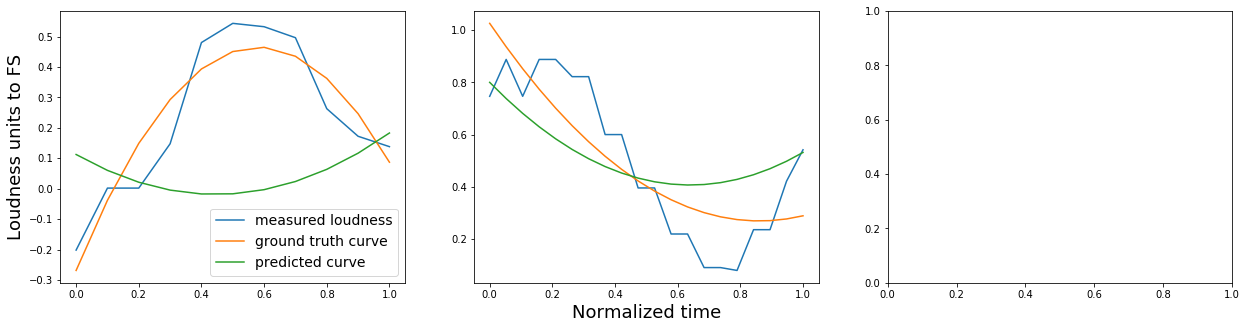

In [84]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 5))
indexes = random.sample(range(0,len(test)),3)
print(indexes)

plt.subplot(131)
lvls, ytest, y = resultForIndex(indexes[0])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS', fontsize=18)
#plt.xlabel('Normalized time', fontsize=18)
plt.legend(loc='lower right', fontsize=14)

plt.subplot(132)
lvls, ytest, y = resultForIndex(indexes[1])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
#plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time', fontsize=18)

plt.subplot(133)
lvls, ytest, y = resultForIndex(indexes[2])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
#plt.ylabel('Loudness units to FS', fontsize=18)
#plt.xlabel('Normalized time', fontsize=18)

plt.savefig('results/result')
plt.show()

In [92]:
intact.motifId.dtype

dtype('O')